# Classification of synapses

In this jupyter notebook, we provide an example of how to extract explainable features and run a classification for the imaging flow cytometry dataset provided by:

scifAI: An explainable AI python framework for the analysis of multi-channel imaging flow cytometry data


We assume you have already installed the library. Otherwise you can install it using 

`!pip -q install <Path to the cloned module>`

This notebook provides an example for deep learning methods

here we import a series of needed modules. 

In [1]:
import scifAI
import numpy as np
from sklearn.datasets import make_classification
import torch.nn as nn
from skorch import NeuralNetClassifier
import matplotlib.pyplot as plt
import glob
from imageio import imread
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
from tqdm import tqdm
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import torch
from torchvision import transforms
from IPython.core.debugger import Tracer
from torch.utils.data import DataLoader, Dataset
from sklearn.pipeline import Pipeline, FeatureUnion
# Compare Algorithms
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import f1_score

In [2]:
from scifAI.dl.utils import calculate_weights, get_statistics
from scifAI.dl.dataset import DatasetGenerator
from scifAI.dl.custom_transforms import ShuffleChannel
from scifAI.dl.models import PretrainedModel, resnet18

In [3]:
from iflai.dl.models import PretrainedModel
from skorch.callbacks import LRScheduler,Checkpoint,EpochScoring,EarlyStopping
import torch.optim as optim
from skorch.helper import predefined_split

here, we provide a function for visualizing the result of the confusion matrix which will be used later.

In [4]:
from sklearn.metrics import (plot_confusion_matrix, 
                             matthews_corrcoef, 
                             classification_report,
                             confusion_matrix, 
                             accuracy_score, 
                             balanced_accuracy_score, 
                             cohen_kappa_score, 
                             f1_score,  
                             precision_score, recall_score)
from imblearn.metrics import classification_report_imbalanced

def classification_complete_report(y_true, y_pred, plot = True ): 
    print(classification_report(y_true, y_pred))
    print(15*"----")
    print("matthews correlation coeff: %.2f" % (matthews_corrcoef(y_true, y_pred)) )
    print("Cohen Kappa score: %.2f" % (cohen_kappa_score(y_true, y_pred)) )
    print("Accuracy: %.2f & balanced Accuracy: %.2f" % (accuracy_score(y_true, y_pred), balanced_accuracy_score(y_true, y_pred)) )
    print("macro F1 score: %.2f & micro F1 score: %.2f" % (f1_score(y_true, y_pred, average = "macro"), f1_score(y_true, y_pred, average = "micro")) )
    print("macro Precision score: %.2f & micro Precision score: %.2f" % (precision_score(y_true, y_pred, average = "macro"), precision_score(y_true, y_pred, average = "micro")) )
    print("macro Recall score: %.2f & micro Recall score: %.2f" % (recall_score(y_true, y_pred, average = "macro"), recall_score(y_true, y_pred, average = "micro")) )
    print(15*"----")
    
    

now lets calculate the metadata:

In [5]:
%%time

metadata = pd.read_csv("/pstore/data/DS4/synapse_data_features/metadata_subset.csv.gz")

CPU times: user 2.28 s, sys: 274 ms, total: 2.56 s
Wall time: 2.56 s


In [6]:
row_index = metadata.set.isin(["train","validation","test"]) 

metadata = metadata.loc[row_index,:].reset_index(drop = True)

metadata

,file,experiment,donor,condition,object_number,set,label
0,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,4147,train,B_cell
1,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,57117,train,B_T_cell_in_one_layer
2,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,48521,test,B_T_cell_in_one_layer
3,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,30947,train,Multiplets
4,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_1,Donor_1,+SEA,38634,train,B_cell
...,...,...,...,...,...,...,...
5216,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,-SEA,22111,train,Multiplets
5217,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,-SEA,28850,validation,No_cell_cell_interaction
5218,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,-SEA,11855,test,T_cell_with_signaling
5219,/pstore/data/DS4/synapse_formation_full_data/E...,Experiment_4,Donor_9,-SEA,18171,train,No_cell_cell_interaction


lets plot a random image per class

B_T_cell_in_one_layer
B_cell
Multiplets
No_cell_cell_interaction
Synapses_with_signaling
Synapses_without_signaling
T_cell
T_cell_with_B_cell_fragments
T_cell_with_signaling


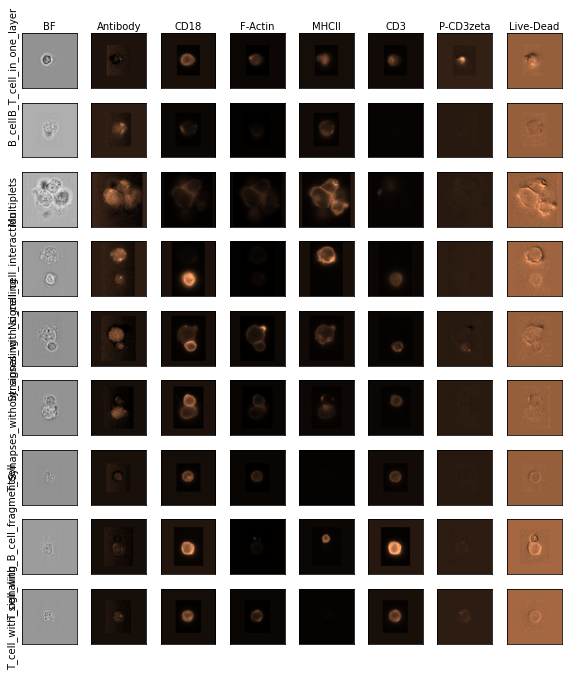

In [7]:
from skimage.util import crop
import h5py

def crop_pad_h_w(image_dummy,reshape_size):
    if image_dummy.shape[0] < reshape_size:
        h1_pad = ( reshape_size - image_dummy.shape[0])/2
        h1_pad = int(h1_pad)
        h2_pad =  reshape_size - h1_pad - image_dummy.shape[0]
        h1_crop = 0
        h2_crop = 0
    else:
        h1_pad = 0
        h2_pad = 0
        h1_crop = ( reshape_size - image_dummy.shape[0])/2
        h1_crop = abs(int(h1_crop))
        h2_crop = image_dummy.shape[0]- reshape_size  - h1_crop

    if image_dummy.shape[1] < reshape_size:
        w1_pad = (reshape_size - image_dummy.shape[1])/2
        w1_pad = int(w1_pad)
        w2_pad = reshape_size - w1_pad - image_dummy.shape[1]
        w1_crop = 0
        w2_crop = 0
    else:
        w1_pad = 0
        w2_pad = 0
        w1_crop = (reshape_size - image_dummy.shape[1])/2
        w1_crop = abs(int(w1_crop))
        w2_crop = image_dummy.shape[1]- reshape_size  - w1_crop

    h = [h1_crop, h2_crop, h1_pad, h2_pad]
    w = [w1_crop, w2_crop, w1_pad, w2_pad] 
    return h, w

def plot_images_with_metadata(metadata,  
                              figsize = None,
                              channels = ["BF","BF", "BF"],
                    channel_colors =  ["Greys", "Oranges", "Blues"],
                    image_size = 128):
    
    metadata_dummy = metadata.copy()
    metadata_dummy = metadata_dummy.reset_index(drop = True)
    
    nrows = len(metadata_dummy)
    ncols = len(channel_colors)
    
    if figsize is None:
        figsize = ( ncols*2, nrows*2 )
    fix,ax = plt.subplots(nrows, ncols, figsize = figsize, tight_layout = True)
    
    vmin = [4095.]*ncols
    vmax = [0.]*ncols
    
    for i in range(nrows):
        h5_file_ = h5py.File(metadata_dummy.loc[i,"file"], "r")
        image = h5_file_.get("image")[()]
        for j, ch in enumerate(range(ncols)):
            vmin[j] = min(vmin[j], image[:,:,ch].min()  )
            vmax[j] = max(vmax[j], image[:,:,ch].max()  )
        
    for i in range(nrows):
        h5_file_ = h5py.File(metadata_dummy.loc[i,"file"], "r")
        image = h5_file_.get("image")[()]         
        
        h, w = crop_pad_h_w(image, image_size)
        h1_crop, h2_crop, h1_pad, h2_pad =  h 
        w1_crop, w2_crop, w1_pad, w2_pad = w 
        for j, ch in enumerate(channel_colors):
            image_dummy = crop(image[:,:,j], ((h1_crop,h2_crop),(w1_crop,w2_crop)))            
            image_dummy = np.pad(image_dummy, 
                                     ((h1_pad,h2_pad),(w1_pad,w2_pad)), 
                                     'constant', 
                                     constant_values = np.mean(image_dummy) )
            ax[i,j].imshow(image_dummy, cmap = channel_colors[j] , vmin = vmin[j], vmax = vmax[j]  )
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
            
            if j == 0:
                print(metadata_dummy.loc[i,"label"])
                ax[i,j].set_ylabel(metadata_dummy.loc[i,"label"])
            if i == 0:
                ax[i,j].set_xlabel(channels[j])
                ax[i,j].xaxis.set_label_position('top') 
            
        h5_file_.close()
    plt.tight_layout()

    
plot_images_with_metadata(metadata.groupby('label').apply(lambda s: s.sample(1, random_state = 3)).reset_index(drop = True) ,  
                              figsize = (8,len(metadata.label.unique())),
                          channels = ["BF","Antibody","CD18","F-Actin","MHCII","CD3","P-CD3zeta","Live-Dead"],
                    channel_colors =  ["Greys", "copper", "copper", "copper", "copper", "copper", "copper", "copper"],
                    image_size = 128)



plt.savefig("Dataset 2 - synapses.png", bbox_inches='tight')
plt.savefig("Dataset 2 - synapses.svg", bbox_inches='tight')

Set all random seeds to the specific value, so the results are more reproducable

In [8]:
seed_value = 42

os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)

np.random.seed(seed_value)
torch.manual_seed(seed_value)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Define all necessary parameters

In [9]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [10]:
class MinMaxScaler(object):
    def __init__(self, min_in , max_in, min_out, max_out):
        self.min_in = min_in.reshape(-1,1,1)
        self.max_in = max_in.reshape(-1,1,1)
        self.min_out = min_out
        self.max_out = max_out
        
    def __call__(self, tensor):
        
        tensor_ = (tensor - self.min_in)/(self.max_in - self.min_in)
        tensor_ = tensor_*(self.max_out - self.min_out) + self.min_out
        tensor_[tensor_<self.min_out]= self.min_out
        tensor_[tensor_>self.max_out]= self.max_out
        return tensor_
    
    def __repr__(self):
        return self.__class__.__name__ + '(min_out={0}, max_out={1})'.format(self.min_out, self.max_out)

In [11]:

model_dir = "models"
log_dir = "logs"
scaling_factor = 4095.
reshape_size = 160
num_classes = len(metadata.label.unique())

In [12]:

channels = np.asarray(["BF","Antibody","CD18","F-Actin","MHCII","CD3","P-CD3zeta","Live-Dead"])
selected_channels = np.arange(len(channels))
num_channels = len(selected_channels)
num_of_all_channels = len(channels)
all_channels = np.arange(num_of_all_channels)

In [13]:
selected_channels

array([0, 1, 2, 3, 4, 5, 6, 7])

In [14]:
batch_size = 128
num_workers = 4
device="cuda"

splitting data to train, validaiton and test

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

skf = StratifiedKFold(n_splits=5, random_state=seed_value, shuffle=True)
main_fold = 2
i = 1
for train_index, test_index in skf.split(metadata.index.tolist(), metadata["label"]):
    if i == main_fold:
        break
    else:
        print(i)
        i+=1


train_index, validation_index, _, _ = train_test_split(train_index, 
                                                    metadata.loc[train_index,"label"].index.tolist(), 
                                                    stratify = metadata.loc[train_index,"label"].tolist(),
                                                    test_size=0.2, 
                                                    random_state=seed_value)

# train_index =  metadata.set.isin(["train"])
# train_index = train_index[train_index].index

# validation_index =  metadata.set.isin(["validation"])
# validation_index = validation_index[validation_index].index

# test_index =  metadata.set.isin(["test"])
# test_index = test_index[test_index].index

1


In [16]:
label_map = dict(zip(sorted(set(metadata.loc[train_index, "label"])), 
                     np.arange(len(set(metadata.loc[train_index, "label"])))))

set_of_interesting_classes = metadata.label.unique().tolist()

label_map

{'B_T_cell_in_one_layer': 0,
 'B_cell': 1,
 'Multiplets': 2,
 'No_cell_cell_interaction': 3,
 'Synapses_with_signaling': 4,
 'Synapses_without_signaling': 5,
 'T_cell': 6,
 'T_cell_with_B_cell_fragments': 7,
 'T_cell_with_signaling': 8}

now we calculate the statistics of every channel to later use for nomalizing the dataset

In [17]:
train_dataset = DatasetGenerator(metadata=metadata.loc[train_index,:],
                                 label_map=label_map,
                                 selected_channels=selected_channels,
                                 scaling_factor=scaling_factor,
                                 reshape_size=reshape_size,
                                 transform=transforms.Compose([]))

In [18]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

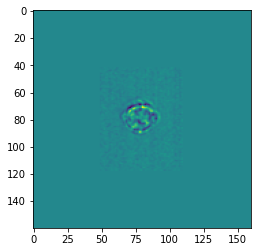

In [19]:
plt.imshow(train_dataset[0][0][0])

In [20]:
statistics = get_statistics(train_loader, selected_channels=selected_channels)

100%|██████████| 27/27 [03:34<00:00,  7.94s/it]

statistics used: {'min': tensor([0.0648, 0.0000, 0.0032, 0.0038, 0.0004, 0.0053, 0.0002, 0.0000]), 'p01': tensor([1.8099e-01, 9.0445e-06, 9.9941e-03, 6.2678e-03, 8.5470e-03, 1.1467e-02,
        8.7349e-03, 8.0586e-03]), 'p05': tensor([0.1874, 0.0005, 0.0104, 0.0069, 0.0090, 0.0120, 0.0091, 0.0085]), 'p25': tensor([0.1926, 0.0011, 0.0129, 0.0109, 0.0094, 0.0135, 0.0093, 0.0086]), 'p50': tensor([0.1960, 0.0017, 0.0164, 0.0157, 0.0131, 0.0195, 0.0095, 0.0088]), 'p75': tensor([0.1986, 0.0021, 0.0198, 0.0219, 0.0189, 0.0255, 0.0099, 0.0090]), 'p95': tensor([0.1996, 0.0030, 0.0295, 0.0435, 0.0350, 0.0404, 0.0104, 0.0093]), 'p99': tensor([0.2076, 0.0056, 0.0593, 0.0876, 0.0693, 0.0860, 0.0113, 0.0104]), 'max': tensor([0.3470, 0.0527, 0.3494, 0.9291, 0.5839, 0.4381, 0.1593, 0.0700]), 'mean': tensor([0.1951, 0.0017, 0.0179, 0.0196, 0.0167, 0.0223, 0.0096, 0.0088]), 'std': tensor([0.0052, 0.0010, 0.0095, 0.0206, 0.0140, 0.0148, 0.0008, 0.0005])}


adding the normalization to each transform

In [21]:
stats = dict()
stats["lower_bound"] = torch.tensor([statistics['min'][0], 
                                     statistics['p01'][1], 
                                     statistics['p01'][2], 
                                     statistics['p01'][3], 
                                     statistics['p01'][4], 
                                     statistics['p01'][5], 
                                     statistics['p01'][6], 
                                     statistics['p01'][7]])

stats["upper_bound"] = torch.tensor([statistics['p99'][0], 
                                     statistics['p99'][1], 
                                     statistics['p99'][2], 
                                     statistics['p99'][3], 
                                     statistics['p99'][4], 
                                     statistics['p99'][5], 
                                     statistics['p99'][6], 
                                     statistics['p99'][7]])

train_transform = [ 
        MinMaxScaler(           min_in =  stats["lower_bound"] , 
                                max_in =  stats["upper_bound"] , 
                                min_out =  0. , 
                                max_out =  1.),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        AddGaussianNoise(mean=0., std=0.01),
]

validation_transform =  [ 
        MinMaxScaler(           min_in =  stats["lower_bound"] , 
                                max_in =  stats["upper_bound"] , 
                                min_out =  0. , 
                                max_out =  1.),
]

test_transform =  [ 
        MinMaxScaler(           min_in =  stats["lower_bound"] , 
                                max_in =  stats["upper_bound"] , 
                                min_out =  0. , 
                                max_out =  1.),
]

In [22]:
train_loader = None

defining train, validation and test datasets

In [23]:
train_dataset = DatasetGenerator(metadata=metadata.loc[train_index,:],
                                 label_map=label_map,
                                 selected_channels=selected_channels,
                                 scaling_factor=scaling_factor, 
                                 reshape_size=reshape_size,
                                 transform= transforms.Compose(train_transform))

validation_dataset = DatasetGenerator(metadata=metadata.loc[validation_index,:],
                                      label_map=label_map,
                                      selected_channels=selected_channels,
                                      scaling_factor=scaling_factor,
                                      reshape_size=reshape_size,
                                      transform=transforms.Compose(test_transform))
test_dataset = DatasetGenerator(metadata=metadata.loc[test_index,:],
                                label_map=label_map,
                                selected_channels=selected_channels,
                                scaling_factor=scaling_factor,
                                reshape_size=reshape_size,
                                transform=
                                transforms.Compose(test_transform))

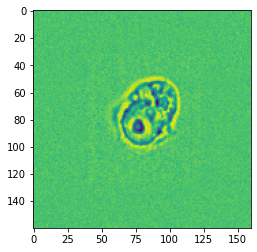

In [24]:
plt.imshow(train_dataset[5][0][0])

considering that we have multiple input channels, we need to modify the ResNet18 network input layer

In [25]:
import torch.nn as nn
from scifAI.dl.models import PretrainedModel
import torch.nn.functional as F

resnet18_modified = PretrainedModel(num_channels= len(channels),
                                     num_classes = len(set_of_interesting_classes), 
                                     pretrained = True)

In [26]:
resnet18_modified

PretrainedModel(
  (model): ResNet(
    (conv1): Conv2d(8, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1

finally, we add a scheduler and an early stopping based on valid_f1_macro

In [27]:
lr_scheduler = LRScheduler(policy='ReduceLROnPlateau', factor=0.5, patience=5)

epoch_scoring_f1_micro = EpochScoring("f1_micro", 
                             name =  "valid_f1_micro", 
                             on_train = False,
                             lower_is_better = False)

epoch_scoring_f1_macro = EpochScoring("f1_macro", 
                             name =  "valid_f1_macro", 
                             on_train = False,
                             lower_is_better = False)

early_stopping = EarlyStopping(monitor='valid_f1_macro', 
                               patience=50, 
                               threshold=0.0001, 
                               threshold_mode='rel', 
                               lower_is_better=False)

checkpoint = Checkpoint(f_params='synapse_formation_DL_fold2.pth',
                        monitor='valid_f1_macro_best', load_best=True)

lets define and train the model using `skorch`

In [28]:
net = NeuralNetClassifier(    
    resnet18_modified, 
    criterion=nn.CrossEntropyLoss,
    lr=0.001,
    batch_size=batch_size,
    max_epochs=1000,
    optimizer=optim.Adam,
    iterator_train__shuffle=True,
    iterator_train__num_workers=num_workers,
    iterator_valid__shuffle=False,
    iterator_valid__num_workers=2,
    callbacks=[lr_scheduler, epoch_scoring_f1_micro, 
               epoch_scoring_f1_macro, 
               early_stopping, checkpoint],
    train_split=predefined_split(validation_dataset),
    device="cuda",
    warm_start=True)

In [29]:
net = net.fit(train_dataset, y = None)

  epoch    train_loss    valid_acc    valid_f1_macro    valid_f1_micro    valid_loss    cp      dur
-------  ------------  -----------  ----------------  ----------------  ------------  ----  -------
      1        0.9463       0.6794            0.6378            0.6794        0.8900     +  12.7506
      2        0.5188       0.7620            0.7190            0.7620        0.6290     +  12.5285
      3        0.4857       0.7404            0.7011            0.7404        0.6482        12.5149
      4        0.3818       0.8062            0.7923            0.8062        0.6502     +  12.4749
      5        0.3893       0.8182            0.7905            0.8182        0.5474        12.5174
      6        0.3247       0.8337            0.7989            0.8337        0.4803     +  12.9504
      7        0.3387       0.7715            0.7691            0.7715        0.6725        12.8813
      8        0.3396       0.8002            0.7863            0.8002        0.6217        12.7002


     76        0.0254       0.8983            0.8936            0.8983        0.4923        12.7347
     77        0.0209       0.9067            0.9031            0.9067        0.4619        12.7668
     78        0.0315       0.8971            0.8929            0.8971        0.5200        12.7272
     79        0.0159       0.9007            0.8972            0.9007        0.5035        12.9131
Stopping since valid_f1_macro has not improved in the last 50 epochs.


In [30]:
net.module.load_state_dict(torch.load('synapse_formation_DL_fold2.pth')) 

<All keys matched successfully>

we stopped the training in 5 epochs. but you can let it train for longer time! :) 

lets take a look the prediction pefromance fore the validation set

In [31]:
inv_label_map = {v: k for k, v in label_map.items()}

preds = net.predict(validation_dataset)
preds =  [inv_label_map[int(t)] for t in preds]

classification_complete_report(validation_dataset.metadata.label, 
                               preds  )

                              precision    recall  f1-score   support

       B_T_cell_in_one_layer       0.95      0.85      0.89        85
                      B_cell       0.96      0.99      0.98       102
                  Multiplets       0.95      0.91      0.93        82
    No_cell_cell_interaction       0.95      0.94      0.94        96
     Synapses_with_signaling       0.85      0.82      0.84       106
  Synapses_without_signaling       0.75      0.82      0.78        79
                      T_cell       0.95      0.93      0.94       107
T_cell_with_B_cell_fragments       0.90      0.97      0.93       100
       T_cell_with_signaling       0.91      0.91      0.91        79

                    accuracy                           0.91       836
                   macro avg       0.91      0.91      0.91       836
                weighted avg       0.91      0.91      0.91       836

------------------------------------------------------------
matthews correlation coeff

and finally for the test set

In [32]:
y_pred = net.predict(test_dataset)
preds =  [inv_label_map[int(t)] for t in y_pred]

classification_complete_report(test_dataset.metadata.label, 
                               preds  )

                              precision    recall  f1-score   support

       B_T_cell_in_one_layer       0.90      0.84      0.87       107
                      B_cell       0.98      0.98      0.98       127
                  Multiplets       0.93      0.93      0.93       102
    No_cell_cell_interaction       0.93      0.92      0.92       120
     Synapses_with_signaling       0.93      0.85      0.89       132
  Synapses_without_signaling       0.74      0.87      0.80        98
                      T_cell       0.92      0.90      0.91       133
T_cell_with_B_cell_fragments       0.88      0.90      0.89       126
       T_cell_with_signaling       0.84      0.88      0.86        99

                    accuracy                           0.90      1044
                   macro avg       0.90      0.90      0.90      1044
                weighted avg       0.90      0.90      0.90      1044

------------------------------------------------------------
matthews correlation coeff

In [33]:
performance_with_all_channels = pd.read_csv("performance_with_all_channels.csv")

performance_with_all_channels.loc[main_fold,"accuracy"] = accuracy_score(test_dataset.metadata.label, preds)
performance_with_all_channels.loc[main_fold,"f1_macro"] = f1_score(test_dataset.metadata.label, preds, average="macro")
performance_with_all_channels.loc[main_fold,"f1_micro"] = f1_score(test_dataset.metadata.label, preds, average="micro")

performance_with_all_channels.to_csv("performance_with_all_channels.csv", index = False)

In [34]:
model = net.module_
resnet18_modified = None
net = None
train_dataset = None
torch.cuda.empty_cache()

### Model Interpretation

In [35]:
# where to save results
model_name = "resnet18"
dataset_name = "synapse formation"


#### Pixel-Permutation Tests

In [36]:
from time import process_time

In [37]:

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [38]:
correct = 0.
total = 0.
y_true = list()
y_pred = list()
y_true_proba = list()
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data[0].to(device).float(), data[1].to(device).long()
        outputs = model(inputs)
        pred = outputs.argmax(dim=1)
        true_proba = np.array([j[i] for (i,j) in zip(pred, outputs.cpu())])
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (labels.reshape(-1) == predicted).sum().item()
        for i in range(len(pred)):
            y_true.append(labels[i].item())
            y_pred.append(pred[i].item())
            y_true_proba.append(true_proba[i].item())

In [39]:
class_names_targets = [c for c in label_map.keys()]
print(classification_report(y_true, y_pred, target_names=class_names_targets, digits=2))

                              precision    recall  f1-score   support

       B_T_cell_in_one_layer       0.90      0.84      0.87       107
                      B_cell       0.98      0.98      0.98       127
                  Multiplets       0.93      0.93      0.93       102
    No_cell_cell_interaction       0.93      0.92      0.92       120
     Synapses_with_signaling       0.93      0.85      0.89       132
  Synapses_without_signaling       0.74      0.87      0.80        98
                      T_cell       0.92      0.90      0.91       133
T_cell_with_B_cell_fragments       0.88      0.90      0.89       126
       T_cell_with_signaling       0.84      0.88      0.86        99

                    accuracy                           0.90      1044
                   macro avg       0.90      0.90      0.90      1044
                weighted avg       0.90      0.90      0.90      1044



100%|██████████| 100/100 [04:38<00:00,  2.79s/it]


Candidate channel  to remove is 0


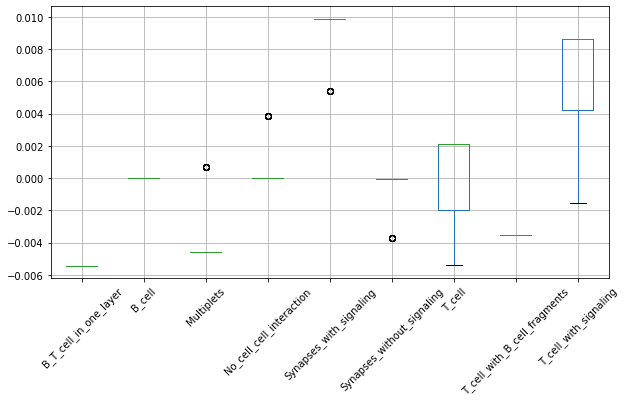

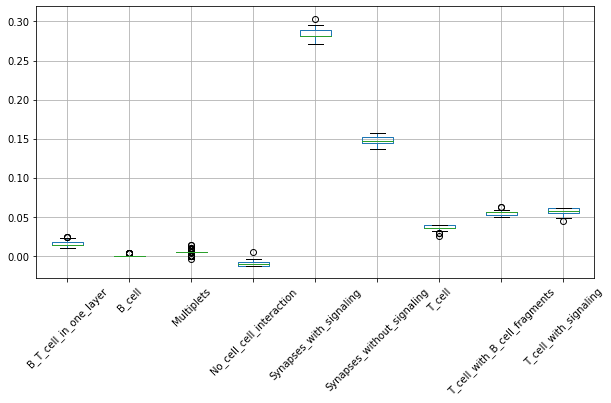

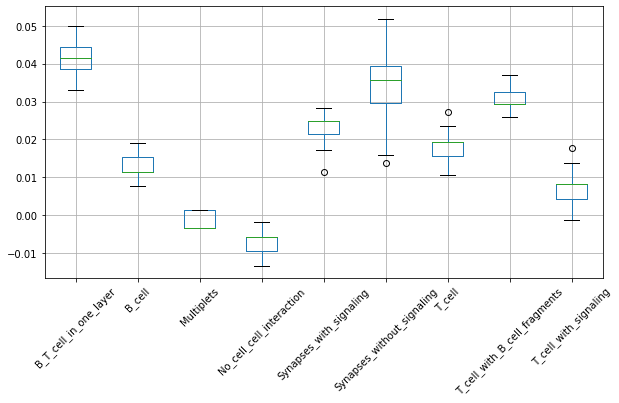

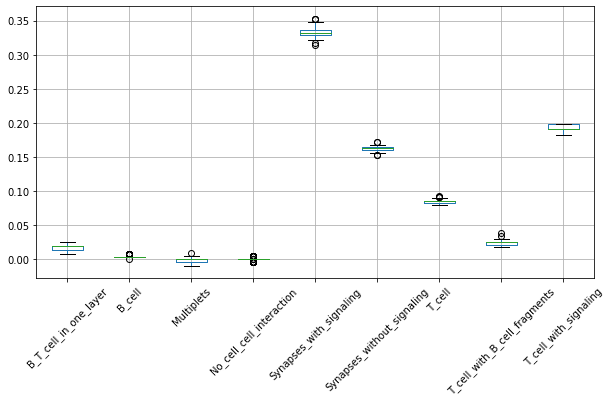

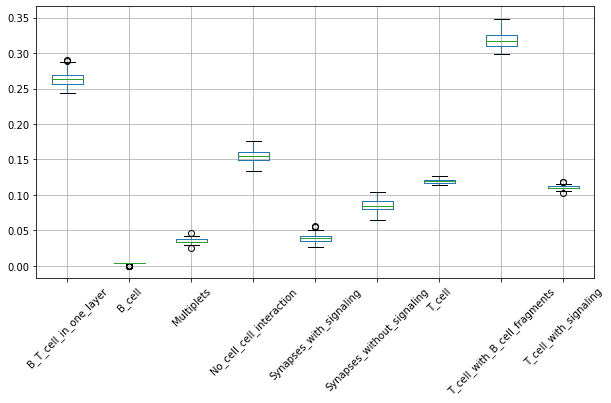

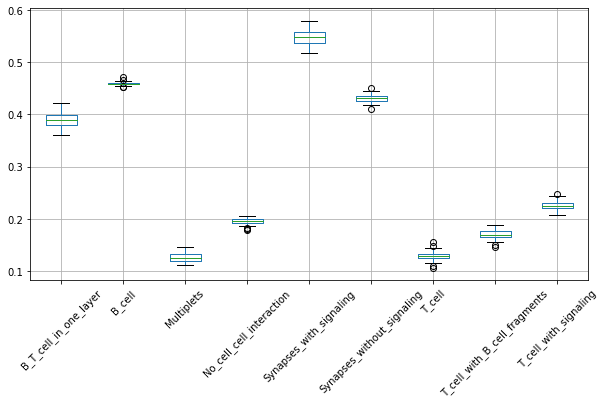

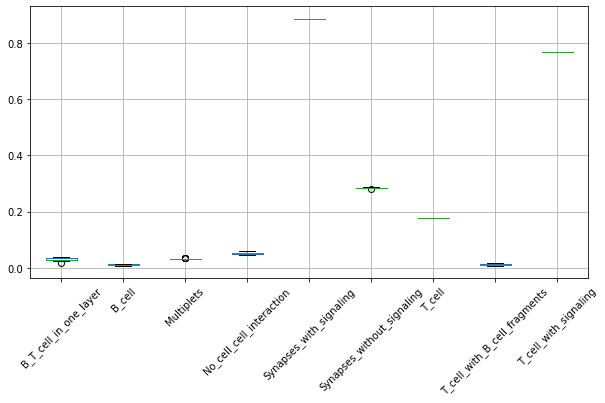

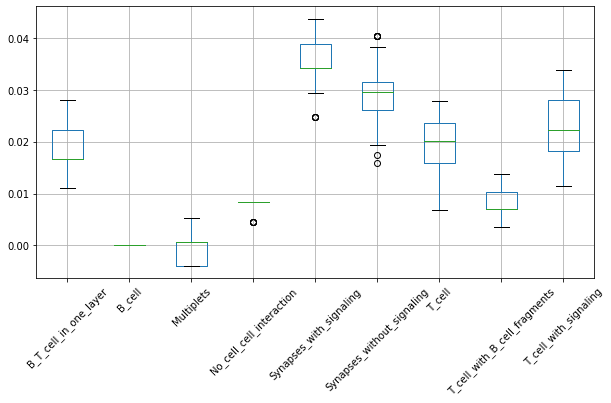

In [40]:
t1_start = process_time()
f1_score_original = f1_score(y_true, y_pred, average=None, labels=np.arange(num_classes))
min_mean_dif = 1.0
candidate = 0
shuffle_times = 100
df_all = pd.DataFrame([], columns=class_names_targets)
for c in range(num_channels):
    f1_score_diff_from_original_per_channel_per_shuffle = []
    transform = test_transform.copy()
    transform.append(ShuffleChannel(channels_to_shuffle=[c]))
    for s in tqdm(range(shuffle_times)):
        dataset = DatasetGenerator(metadata=metadata.loc[test_index,:],
                                 label_map=label_map,
                                 selected_channels=selected_channels,
                                 scaling_factor=scaling_factor,
                                 reshape_size=reshape_size,
                                 transform=transforms.Compose(transform))
        dataloader = DataLoader(dataset,
                                batch_size=batch_size,
                                shuffle=False,
                                num_workers=num_workers)
        y_true = list()
        y_pred = list()
        with torch.no_grad():
            for data in dataloader:
                inputs, labels = data[0].to(device).float(), data[1].to(device).reshape(-1).long()
                outputs = model(inputs)
                pred = outputs.argmax(dim=1)
                for i in range(len(pred)):
                    y_true.append(labels[i].item())
                    y_pred.append(pred[i].item())
            f1_score_per_channel = f1_score(y_true, y_pred, average=None, labels=np.arange(num_classes))
            f1_score_diff_from_original_per_channel_per_shuffle.append(f1_score_original - f1_score_per_channel)
    mean_along_columns = np.mean(f1_score_diff_from_original_per_channel_per_shuffle, axis=0)
    mean_dif = np.mean(mean_along_columns)
    if mean_dif < min_mean_dif and mean_dif > 0 and not selected_channels[c]:
        min_mean_dif = mean_dif
        candidate = selected_channels[c]
    df_diff = pd.DataFrame(np.atleast_2d(f1_score_diff_from_original_per_channel_per_shuffle), columns=class_names_targets)
    df_mean_diff = pd.DataFrame(np.atleast_2d(mean_along_columns), columns=class_names_targets)
    df_all = pd.concat([df_all, df_mean_diff], ignore_index=True, sort=False)
    fig, ax = plt.subplots(figsize=(10, 5))
    ax = df_diff.boxplot()
    ax.set_xticklabels(class_names_targets, rotation=45)
    #fig.savefig(os.path.join("results",model_name, "{}-shuffle_method-model-{}-channel-{}.png".format(dataset_name, str(model_name), str(selected_channels[c]))))
print("Candidate channel  to remove is {}".format(candidate))

<BarContainer object of 8 artists>

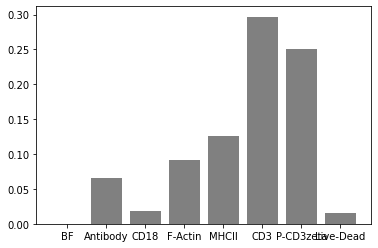

In [41]:
plt.bar(channels[selected_channels], df_all.T.mean(), color='Grey')
#plt.savefig(os.path.join("results",model_name, "{}-pixel-permutation-method-model-all-{}.svg".format(dataset_name, str("resnet_all"))))

In [42]:
channel_ranking_pixel_permutation = pd.DataFrame(data={'channels': channels[np.asarray(selected_channels)], 'importance': df_all.T.mean().to_numpy()})

In [43]:
from captum.attr import (
    GuidedGradCam,
    DeepLift,
    Saliency,
    DeepLiftShap,
    GradientShap,
    InputXGradient,
    IntegratedGradients,
    GuidedBackprop,
    Deconvolution,
    Occlusion,
    FeaturePermutation,
    ShapleyValueSampling,
    Lime,
    KernelShap,
    LRP
)
from time import process_time

In [44]:
def run_interpretation_method(ablator, method_name, require_baseline=False, require_sliding_window=False):
    batch_size = 16
    t1_start = process_time()
    dataset = DatasetGenerator(metadata=metadata.loc[test_index,:],
                                     label_map=label_map,
                                     selected_channels=selected_channels,
                                     scaling_factor=scaling_factor,
                                     reshape_size=reshape_size,
                                     transform=transforms.Compose(test_transform))
    testloader = DataLoader(test_dataset,
                                    batch_size=batch_size,
                                    shuffle=False,
                                    num_workers=num_workers)

    heatmaps = torch.empty(0, dtype=torch.float32, device=device)
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data[0].to(device).float(), data[1].to(device).reshape(-1).long()
            if require_baseline:
                baselines=torch.zeros(inputs.shape).to(device)
                attr = ablator.attribute(inputs, target=labels, baselines=baselines)
            elif require_sliding_window:
                attr = ablator.attribute(inputs, target=labels, sliding_window_shapes=(1,3,3))
            else:
                attr = ablator.attribute(inputs, target=labels)
            heatmaps = torch.cat((heatmaps,  torch.from_numpy(np.percentile(torch.flatten(attr, start_dim=-2).cpu().numpy(), q=50, axis=-1)).to(device)))
    heatmaps_mean = torch.mean(heatmaps, dim=0)
    plt.bar(channels, heatmaps_mean.cpu(), color='grey')
    #plt.savefig(os.path.join("results", "resnet_all", "{}-{}_method-model-50-percentile-{}.png".format(dataset_name, method_name, str("resnet_all"))))

    t1_stop = process_time()
    print("Elapsed time:", t1_stop, t1_start) 

    print("Elapsed time during the whole program in seconds:",
                                             t1_stop-t1_start)
    return heatmaps_mean

In [45]:
# DeepLift

Elapsed time: 1926.240892332 1916.566541222
Elapsed time during the whole program in seconds: 9.674351109999861


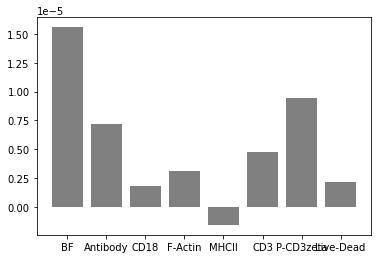

In [46]:
dl = DeepLift(model)
heatmaps_deeplift_mean = run_interpretation_method(dl, 'dl')
dl = None
torch.cuda.empty_cache()

In [47]:
# Saliency

Elapsed time: 1934.545998366 1926.405512155
Elapsed time during the whole program in seconds: 8.140486211000052


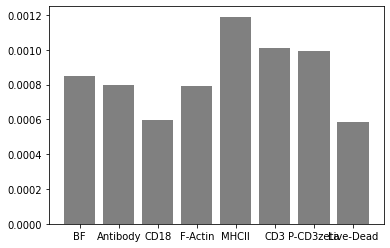

In [48]:
saliency = Saliency(model)
heatmaps_saliency_mean = run_interpretation_method(saliency, 'saliency')
saliency = None
torch.cuda.empty_cache()

In [49]:
# IntegratedGradients

Elapsed time: 2006.514056653 1934.7035858
Elapsed time during the whole program in seconds: 71.81047085299997


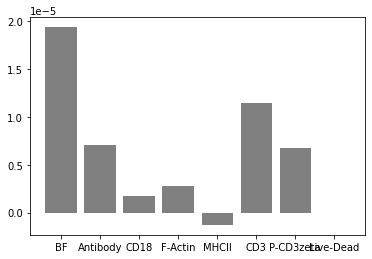

In [50]:
ig = IntegratedGradients(model)
heatmaps_integrated_gradient_mean = run_interpretation_method(ig, 'IntegratedGradients')
ig = None
torch.cuda.empty_cache()

In [51]:
# LRP

Elapsed time: 2015.753298635 2006.74365082
Elapsed time during the whole program in seconds: 9.00964781499988


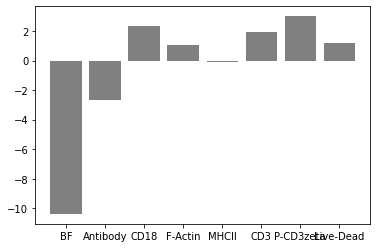

In [52]:
lrp = LRP(model)
heatmaps_lrp_mean = run_interpretation_method(lrp, 'LRP')
lrp = None
torch.cuda.empty_cache()

In [53]:
# GuidedGradCAM

Elapsed time: 2024.644416569 2015.909098305
Elapsed time during the whole program in seconds: 8.735318263999943


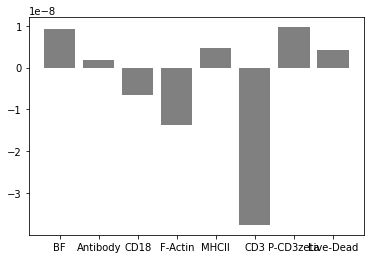

In [54]:
guided_cram = GuidedGradCam(model, model.model.layer1)
heatmaps_gradcam_mean = run_interpretation_method(guided_cram, 'GuidedGradCam')
guided_cram = None
torch.cuda.empty_cache()

In [55]:
channel_importance = pd.read_csv("channel_importance.csv")

channel_importance_fold = pd.DataFrame(columns = channel_importance.columns)

channel_importance_fold["channel"] = channels
channel_importance_fold["fold"] = main_fold
channel_importance_fold["PXPermute"] = channel_ranking_pixel_permutation["importance"]
channel_importance_fold["DeepLift"] = heatmaps_deeplift_mean.cpu().numpy()
channel_importance_fold["IntegratedGradients"] = heatmaps_integrated_gradient_mean.cpu().numpy()
channel_importance_fold["LRP"] = heatmaps_lrp_mean.cpu().numpy()
channel_importance_fold["GuidedGradCAM"] = heatmaps_gradcam_mean.cpu().numpy()

channel_importance = channel_importance.append(channel_importance_fold, ignore_index = True)

channel_importance.to_csv("channel_importance.csv", index = False)

5fold CV on the data and get the importance per fold for statistical evaluation
    
our result is in alignment with the original paper. On the other hand, guided gradcam failed